In [1]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
rundata = loadmat('maze2_run_v1_3_v2_5_500ms_new.mat')
rundata

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Jul 13 16:20:28 2022',
 '__version__': '1.0',
 '__globals__': [],
 'info': array(['savgol_filter width: 21               ',
        'minimum running epoch length: 0.05s*20',
        'time bin size: 500ms                  '], dtype='<U38'),
 'pos_linear': array([[119.41412255, 121.5033644 , 123.89824173, ..., 102.02456408,
         123.92536552, 147.43502013]]),
 'pos_origin': array([[ 36.96597214,  39.19346138,  41.25602181, ...,  19.68333013,
          41.75117733,  64.83698756],
        [-56.40360895, -56.62850528, -60.12628611, ..., -57.11342652,
         -57.13824763, -53.83631318]]),
 'spikes': array([[ 1,  0,  1, ...,  7, 11, 15],
        [ 0,  0,  3, ...,  0,  1,  0],
        [ 0,  2,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  1, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  2, ...,  1,  3,  0]]),
 'time': array([[20768.15      , 20768.65      , 20769.15      , ...,
  

In [3]:
rundata['pos_linear'].shape

(1, 1156)

In [4]:
spikes0 = rundata['spikes']
position0 = rundata['pos_linear'].squeeze()
time0 = rundata['time'].squeeze()
spikes0.shape, position0.shape, time0.shape

((109, 1156), (1156,), (1156,))

In [5]:
del rundata

[Load PBE nel](#loadPBE)

[Choose PBE time bin size by MAP PBE posterior](#MAP)

## Decide included segments (forward/backward/all)

In [6]:
from scipy.signal import savgol_filter

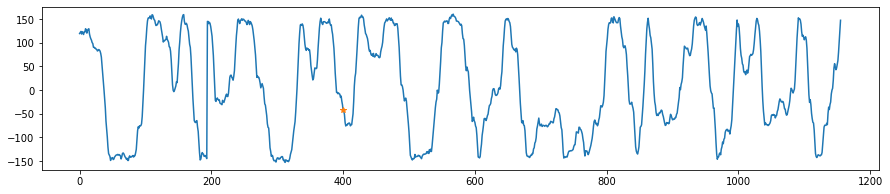

In [11]:
trim_st = 400 # maze1 500:(100ms), 130:(500ms); maze2 1000:(100ms), 400:(500ms)

plt.figure(figsize=(15,3))
plt.plot(position0)
plt.plot(trim_st,position0[trim_st],'*')

In [12]:
position = position0[trim_st:] # maze1 500:, maze2 1000:
spikes = spikes0[:,trim_st:] #spikes0[normalcell,1000:]
time = time0[trim_st:]
spikes.shape, position.shape, time.shape

((109, 756), (756,), (756,))

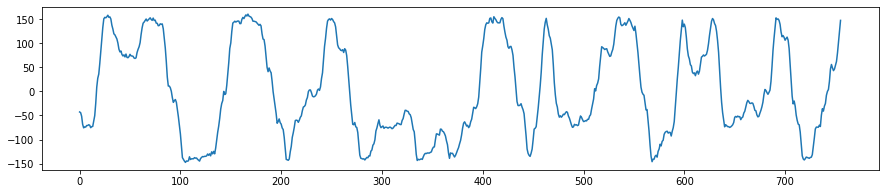

In [13]:
plt.figure(figsize=(15,3))
plt.plot(position)

In [14]:
peaks = []
# manualseg = [0,150,270,320,450,600,685] # maze1 500ms
manualseg = [0,50,100,200,290,340,370,450,500,570,610,650,720,756] # maze2 500ms
for i in range(len(manualseg)-1):
    peaks.append(np.argmax(position[manualseg[i]:manualseg[i+1]])+manualseg[i])

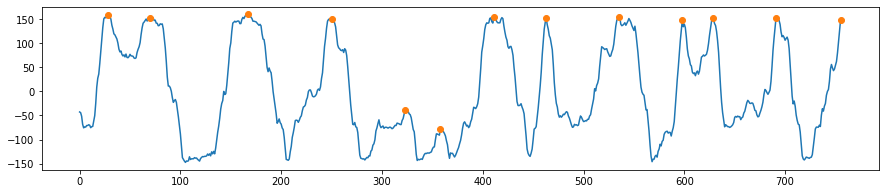

In [15]:
plt.figure(figsize=(15,3))
plt.plot(position)
plt.plot(peaks,position[peaks],'o')

In [16]:
peaks_r = [np.argmin(position[0:peaks[0]])]
for i in range(len(peaks)-1):
    peaks_r.append(np.argmin(position[peaks[i]:peaks[i+1]])+peaks[i])
peaks_r.append(position.shape[0]-1)

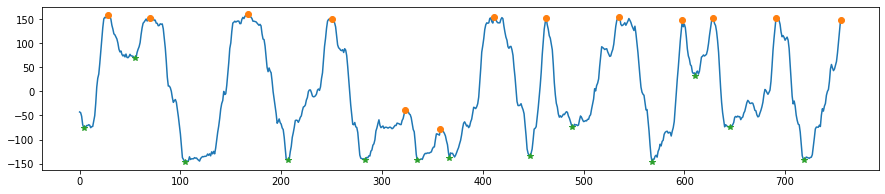

In [19]:
plt.figure(figsize=(15,3))
plt.plot(position)
plt.plot(peaks,position[peaks],'o')
plt.plot(peaks_r,position[peaks_r],'*')

In [18]:
peaks_r = peaks_r[:-1]

In [20]:
peaks = np.array(peaks)
peaks_r = np.array(peaks_r)

In [21]:
# forward
fwd_lst = []
for i in range(1,len(peaks)): # ignore the first few laps b/c maybe unstable
    fwd_lst.append(np.arange(peaks_r[peaks_r<peaks[i]][-1],peaks[i]))

fwd = np.concatenate(fwd_lst)

In [22]:
# backward
bwd_lst = []
for i in range(1,len(peaks_r)): # ignore the first few laps b/c maybe unstable
    bwd_lst.append(np.arange(peaks[peaks<peaks_r[i]][-1],peaks_r[i]))

bwd = np.concatenate(bwd_lst)

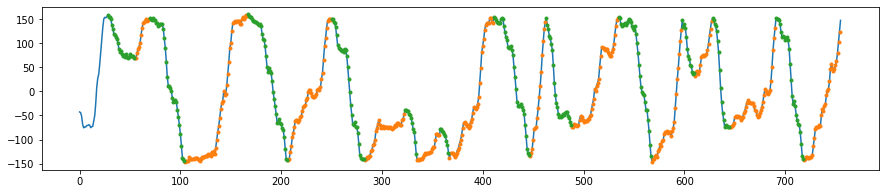

In [23]:
plt.figure(figsize=(15,3))
plt.plot(position)
plt.plot(fwd,position[fwd],'.')
plt.plot(bwd,position[bwd],'.')

In [24]:
spikes.shape

(109, 756)

In [25]:
# all
# alldir = np.arange(400,position.shape[0]) # maze2
alldir = np.arange(0,position.shape[0]) # maze1: ignore the first 900 points
alldir_lst = [alldir]

## Get place cell ids and place fields

In [28]:
(position.max()-position.min())/30

10.261788205203626

In [29]:
def get_place_cell(position,spikes,fwd,n_std=3):
    '''Get index of place cells and their place field.
    
       Parameters
       ------------------------
       position: animal position, size of (#sample, )
       spikes: binned spike data, size of (#neuron, #sample)
       fwd: indices of included time points, foward/backward/all...
       n_std: creteria of place cell qualification, number of stds the peak_firing_rate above mean_firing_rate
       
       Returns
       ------------------------
       place_cell: indices of qualified place cells, size of (#place_cells, )
       field: spatial bin with maximum firing rate of corresponding place cells, size of (#place_cells, )
       '''
    
    # spatial bins
    pos = np.round((position-position.min())/(position.max()-position.min())*29)
    pos_list = np.unique(pos)

    # get average tc of segments
    seg_tc = []
    seg_sp = spikes[:,fwd]
    seg_pos = pos[fwd]
    for p in pos_list:
        if seg_pos[seg_pos==p].size>0:
            seg_tc.append((seg_sp[:,seg_pos==p]).mean(axis=1))
        else:
            seg_tc.append(np.zeros(spikes.shape[0]))  
    seg_tc = np.array(seg_tc)
            
    # get place cells
    place_cell = []
    field = []
    for i in range(spikes.shape[0]):
        if seg_tc[:,i].max()>0.3:
            m = seg_tc[:,i].argmax()
            thr = seg_tc[:,i].mean()+n_std*seg_tc[:,i].std()
            if seg_tc[m,i]>thr:
                place_cell.append(i)
                field.append(m)
    field = np.array(field)

    # plot tuning curves of place cells
    order = np.argsort(field)
    plotting = seg_tc[:,place_cell] / seg_tc[:,place_cell].max(axis=0)

    plt.imshow(plotting[:,order])
    plt.xlabel('#cell')
    plt.ylabel('Spatial Bins')
    
    return place_cell, field, seg_tc

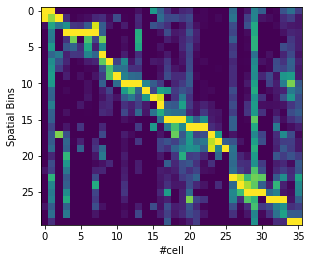

In [30]:
fwdplace_cell, fwdfield, seg_tc_fwd = get_place_cell(position,spikes,fwd,3)

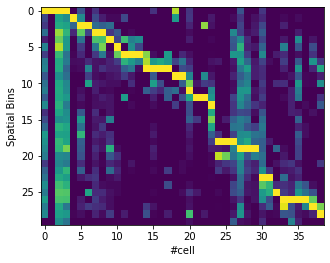

In [31]:
bwdplace_cell, bwdfield, seg_tc_bwd = get_place_cell(position,spikes,bwd,3)

In [32]:
seg_tc_fwd.shape, seg_tc_bwd.shape

((30, 109), (30, 109))

In [33]:
len(fwdplace_cell), len(bwdplace_cell)

(36, 39)

In [34]:
place_cell = np.union1d(fwdplace_cell,bwdplace_cell) # union of forward place cells and backward place cells
place_cell.shape

(50,)

In [35]:
field = np.zeros_like(place_cell)
for c,f in zip(fwdplace_cell,fwdfield):
    field[place_cell==c]=f
    
for c,f in zip(bwdplace_cell,bwdfield):
    field[place_cell==c]=f

In [36]:
place_cell = np.array(place_cell)
field.shape,place_cell.shape

((50,), (50,))

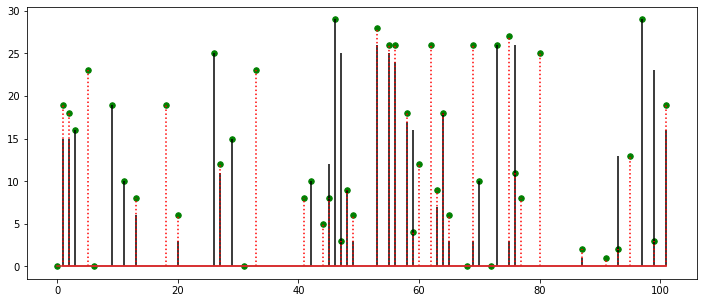

In [37]:
plt.figure(figsize=(12,5))
plt.stem(fwdplace_cell,fwdfield,linefmt='k',markerfmt='None')
plt.stem(bwdplace_cell,bwdfield,linefmt='r:',markerfmt='None')
plt.scatter(place_cell,field,c='g',s=30,marker='o')

## Cross-Correlation Histogram

In [38]:
def get_delays(place_cell,fwd_lst,spikes,field,r=40):
    """Get spike delays between all pairs of place cells.
    
    Parameters
    ---------------------------
    place_cell: indices of qualified place cells, of size (#place_cells, )
    fwd_lst: list of arrays, each array includes indices of continuous included time points
    spikes: binned spike data, size of (#neuron, #sample)
    field: spatial bin with maximum firing rate of corresponding place cells, size of (#place_cells, )
    r: suppose spike1 occurred at t, we only compute delays of spikes within time window t+-r
    
    Returns
    ---------------------------
    pairs_dis: pairwise distances of place fields, size of (#place_cell*(#place_cell-1)/2, )
    DELAYS: spike delays between all pairs of place cells, list with size of (#place_cell*(#place_cell-1)/2, )
    """
    DELAYS = []
    pairs_dis = []

    for idx1 in range(len(place_cell)):
        cell1 = place_cell[idx1]
        for idx2 in range(idx1+1,len(place_cell)):
            cell2 = place_cell[idx2]
            delays = []
            for seg in fwd_lst:
                l = len(seg)
                seg_spk1 = spikes[cell1,seg]
                seg_spk2 = spikes[cell2,seg]
                for i in np.where(seg_spk1!=0)[0]:
                    segseg = seg_spk2[max(0,i-r):min(l,i+r)]
                    for j in np.where(segseg!=0)[0]:
                        delays.append(np.ones(seg_spk1[i]*segseg[j])*(i-j-max(0,i-r)))

            pairs_dis.append(field[idx1]-field[idx2])
            if len(delays)>0:
                DELAYS.append(np.concatenate(delays))
            else:
                DELAYS.append(np.array([]))

    pairs_dis = np.array(pairs_dis)
    return pairs_dis, DELAYS

In [39]:
def get_CCH(DELAYS,binsize=1,bins=79):
    '''Get cross-correlogram of all pairs of place cells.
    
    Parameters
    ----------------
    DELAYS: spike delays between all pairs of place cells, list with size of (#place_cell*(#place_cell-1)/2, )
    binsize: scalar, histogram bin size, unit:s or bin. 
       For run data (1 time bin per histogram bin); 
       Exact duration in second for pbe data (0.2 indicated 200ms).
    bins: scalar, number of bins for histogram
    
    Returns
    ----------------
    CCH: cross-correlogram of all pairs of place cells, size of (#place_cell*(#place_cell-1)/2,bins)
    '''
    CCH = []
    r = binsize*(bins-1)/2

    for delays in DELAYS:
        if len(delays)>0:
            hist, _ = np.histogram(delays,bins=bins,range=(-r,r))
        else:
            hist = np.zeros(bins)
                
        CCH.append(hist)

    CCH = np.array(CCH)
    return CCH

In [40]:
def plot_CCH(CCH,pairs_dis,r=39,dis_abs=False):
    """
    Parameters
    ---------------------
    CCH: cross-correlogram of all pairs of place cells, size of (#place_cell*(#place_cell-1)/2,bins)
    pairs_dis: pairwise distances of place fields, size of (#place_cell*(#place_cell-1)/2, )
    r: scalar, binsize*(bins+1)/2, the true histogram range on either side of 0, just be used for axis ticks
    dis_abs: True, place cell pairs sorted by absolute values of field distance
    """
    CCH_n = CCH/CCH.max(axis=1)[:,np.newaxis]
    CCH_n[CCH.max(axis=1)==0,:] = np.zeros_like(CCH[0,:])
    if dis_abs:
        order_pair = np.argsort(np.abs(pairs_dis))
    else:
        order_pair = np.argsort(pairs_dis)
    CCH_plot = CCH_n[order_pair[::-1],:]
    plt.imshow(CCH_plot,aspect='auto',extent=(-r,r,0,250))
#     plt.imshow(CCH_plot,aspect='auto',extent=(-r,r,pairs_dis[order_pair[-1]],pairs_dis[order_pair[0]]))
    plt.xlabel('Time Bin')
    if dis_abs:
        plt.ylabel(f'Place Field Distance ({CCH.shape[0]} pairs)')
    else:
        plt.ylabel(f'Place Field Distance ({CCH.shape[0]} pairs)')
    
    return CCH_plot

In [41]:
len(alldir_lst[0]), spikes.shape, len(place_cell)

(756, (109, 756), 50)

In [42]:
pairs_dis, DELAYS = get_delays(place_cell,alldir_lst,spikes,field,r=20)
len(DELAYS),pairs_dis.shape

(1225, (1225,))

In [43]:
u = np.unique(np.concatenate(DELAYS))
u.shape

(40,)

In [44]:
CCH = get_CCH(DELAYS,binsize=1,bins=39)
CCH.shape

(1225, 39)

Text(0.5, 1.0, 'Cross-Correlation Counts (Fwd place cells)')

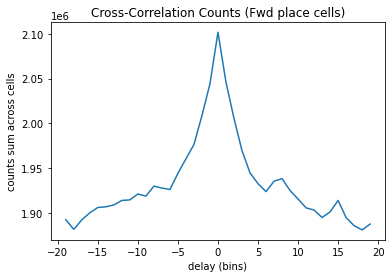

In [45]:
plt.plot(np.arange(-19,20),CCH.sum(axis=0))
plt.xlabel('delay (bins)')
plt.ylabel('counts sum across cells')
plt.title('Cross-Correlation Counts (Fwd place cells)')

<ipython-input-40-690a70cfdad0>:10: RuntimeWarning: invalid value encountered in true_divide
  CCH_n = CCH/CCH.max(axis=1)[:,np.newaxis]


Text(0.5, 1.0, 'maze2 running (400:end) binned in 500ms time bin')

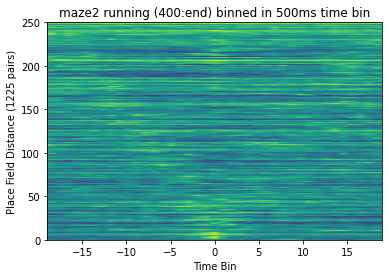

In [49]:
CCH_plot = plot_CCH(CCH,pairs_dis,r=19,dis_abs=True)
plt.title('maze2 running ('+str(trim_st)+':end) binned in 500ms time bin')

In [50]:
CCH.shape,pairs_dis.shape

((1225, 39), (1225,))

In [51]:
np.savez('CCH_alldircell_'+str(trim_st)+'toendrun_maze2.npz',CCH=CCH,place_cell=place_cell,field=field,pairs_dis=pairs_dis)

In [11]:
# CCH = np.load('CCH_alldircell_140toendrun_maze2.npz',allow_pickle=True)['CCH']
# pairs_dis = np.load('CCH_alldircell_140toendrun_maze2.npz',allow_pickle=True)['pairs_dis']
place_cell = np.load('CCH_alldircell_140toendrun_maze1.npz',allow_pickle=True)['place_cell']
field = np.load('CCH_alldircell_140toendrun_maze1.npz',allow_pickle=True)['field']

In [52]:
place_cell.shape,field.shape,CCH.shape

((50,), (50,), (1225, 39))

<a id='loadPBE'></a>
# PBEs

In [1]:
import warnings
warnings.filterwarnings("ignore")

import nelpy as nel
import pandas as pd
import os
import sys
import warnings
import numpy as np
import pickle
import random

import copy
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat

In [2]:
from scipy.stats import pearsonr

In [9]:
PBEs_origin = nel.load_pkl('pbe_pre.nel')
PBEs_origin

<SpikeTrainArray at 0x7f1384e37100: 109 units (3,155 segments)> at 30000 Hz

In [55]:
d = np.load('/home/kemerelab/Downloads/mazesEEG/RatS-Day5TwoNovel-2020-12-04_07-55-09.paradigm.npy',allow_pickle=True)
# Define maze ID
maze_id = 3
runepoch = nel.EpochArray([time[0],d.item(0)['epochs']['stop'].values[maze_id]])
runepoch

<EpochArray at 0x7fd91f0a8fa0: 1 epoch> of length 37:12:500 minutes

In [56]:
del d

In [58]:
PBEs_origin.support

<EpochArray at 0x7fd8fcc95a60: 831 epochs> of length 3:14:018 minutes

In [59]:
PBEs_origin = PBEs_origin[runepoch]

In [60]:
PBEs_origin.support

<EpochArray at 0x7fd8fcc42d30: 658 epochs> of length 2:33:976 minutes

## Bin and save PBEs

In [10]:
spikes = PBEs_origin.bin(ds=0.014)
spikes.data.shape

(109, 42528)

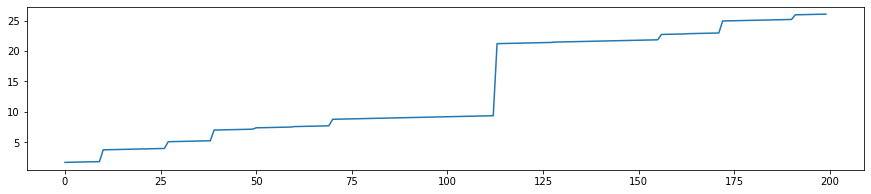

In [11]:
plt.figure(figsize=(15,3))
plt.plot(spikes.bin_centers[:200])

In [12]:
spikes.binned_support

array([[    0,     9],
       [   10,    26],
       [   27,    38],
       ...,
       [42502, 42512],
       [42513, 42520],
       [42521, 42527]])

In [13]:
dic = {"time": spikes.bin_centers, "event_edge": spikes.binned_support, "spikes": spikes.data}
dic

{'time': array([1.65493333e+00, 1.66893333e+00, 1.68293333e+00, ...,
        1.10484049e+04, 1.10484189e+04, 1.10484329e+04]),
 'event_edge': array([[    0,     9],
        [   10,    26],
        [   27,    38],
        ...,
        [42502, 42512],
        [42513, 42520],
        [42521, 42527]]),
 'spikes': array([[1, 1, 1, ..., 0, 1, 1],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 2, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])}

In [14]:
savemat('pbe_pre_14ms.mat',dic)

--------------------- end saving binned PBEs ---------------------------

In [64]:
seg = PBEs_origin[PBEs_origin.support[3]].data
seg

array([array([11322.34353333, 11322.34716667, 11322.34993333, 11322.3527    ,
       11322.3612    , 11322.36846667, 11322.3749    , 11322.37746667,
       11322.38086667, 11322.38336667, 11322.38853333, 11322.39773333,
       11322.40843333]),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64),
       array([11322.33153333, 11322.338     , 11322.35193333, 11322.35433333,
       11322.35593333, 11322.3649    , 11322.36726667, 11322.3759    ,
       11322.379     ]),
       array([], dtype=float64), array([11322.40203333]),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([11322.37626667, 11322.3913    , 11322.39716667]),
       array([11322.38403333]), array([], dtype=float64),
       array([], dtype=float64),
       array([11322.31266667, 11322.3398    , 11322.34093333, 11322.35803333,
       11322.4005    , 11322.40563333]),
       array([], dtype=float64), array(

In [61]:
segs = []
K = 0 #len(PBEs_origin.support.data)
for k in range(K,len(PBEs_origin.support.data)):
    segs.append(PBEs_origin[PBEs_origin.support[k]].data)
segs

[array([array([21778.31606667]), array([21778.16666667]),
        array([], dtype=float64), array([21778.29123333, 21778.30196667]),
        array([21778.1696    , 21778.2328    , 21778.25396667, 21778.34616667,
        21778.35113333]),
        array([], dtype=float64),
        array([21778.1116    , 21778.14683333, 21778.18996667, 21778.23536667,
        21778.2511    , 21778.26756667, 21778.2975    , 21778.3032    ,
        21778.3476    , 21778.35306667, 21778.35693333, 21778.36513333]),
        array([], dtype=float64), array([], dtype=float64),
        array([], dtype=float64), array([], dtype=float64),
        array([21778.16816667, 21778.2256    , 21778.23436667]),
        array([21778.12186667, 21778.14013333]), array([21778.1696]),
        array([], dtype=float64),
        array([21778.16903333, 21778.1737    , 21778.1882    , 21778.21233333,
        21778.2265    , 21778.23166667, 21778.23503333, 21778.27676667,
        21778.2812    , 21778.3013    , 21778.3158    , 21778.3

In [62]:
len(segs)

658

In [63]:
def get_delays_pbe(place_cell,segs,field):
    DELAYS = []
    pairs_dis = []

    K = len(segs)
    for idx1 in range(len(place_cell)):
        cell1 = place_cell[idx1]
        for idx2 in range(idx1+1, len(place_cell)):
            cell2 = place_cell[idx2]

            delays = []
            for k in range(K):
                seg = segs[k]
                seg_spk1 = seg[cell1]
                seg_spk2 = seg[cell2]
                if (len(seg_spk1)>0) & (len(seg_spk2)>0):
                    for i in seg_spk1:
                        delays.append(seg_spk2-i)
                        
            pairs_dis.append(field[idx1]-field[idx2])
            if len(delays)>0:
                DELAYS.append(np.concatenate(delays))
            else:
                DELAYS.append(np.array([]))

    pairs_dis = np.array(pairs_dis)
    
    return pairs_dis, DELAYS

In [64]:
pairs_dis_pbe, DELAYS_pbe = get_delays_pbe(place_cell,segs,field)

In [65]:
np.savez('delays_runepochPBEs'+str(trim_st)+'toend_allplacecell_maze2', DELAYS=DELAYS_pbe, pairs_dis=pairs_dis_pbe)

In [66]:
len(DELAYS_pbe),pairs_dis_pbe.shape

(1225, (1225,))

In [ ]:
DELAYS_pbe = np.load('delays_runepochPBEs'+str(trim_st)+'toend_allplacecell_maze1.npz',allow_pickle=True)['DELAYS']
pairs_dis_pbe = np.load('delays_runepochPBEs'+str(trim_st)+'toend_allplacecell_maze1.npz',allow_pickle=True)['pairs_dis']

In [94]:
CCH_pbe = get_CCH(DELAYS_pbe,binsize=0.02,bins=39)
CCH_pbe.shape

(1225, 39)

In [95]:
r=0.014*20

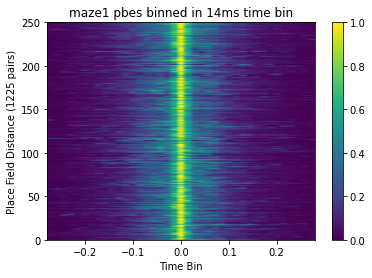

In [96]:
CCH_pbe_plot = plot_CCH(CCH_pbe,pairs_dis_pbe,dis_abs=True,r=r)
plt.title('maze1 pbes binned in 14ms time bin')
plt.colorbar()

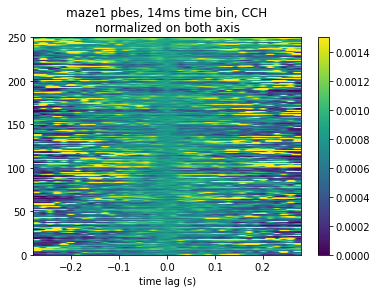

In [97]:
CCH_n = CCH_pbe_plot/CCH_pbe_plot.sum(axis=0)
plt.imshow(CCH_n,aspect='auto',extent=(-r,r,0,250),vmax=0.0015)
plt.title('maze1 pbes, 14ms time bin, CCH\nnormalized on both axis')
plt.xlabel('time lag (s)')
plt.colorbar()

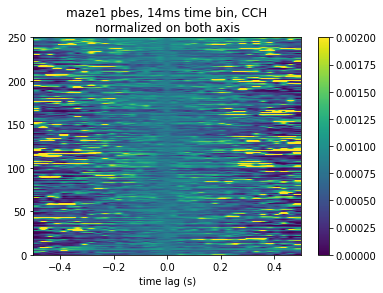

In [84]:
CCH_n = CCH_pbe_plot/CCH_pbe_plot.sum(axis=0)
plt.imshow(CCH_n,aspect='auto',extent=(-r,r,0,250),vmax=0.002)
plt.title('maze1 pbes, 14ms time bin, CCH\nnormalized on both axis')
plt.xlabel('time lag (s)')
plt.colorbar()

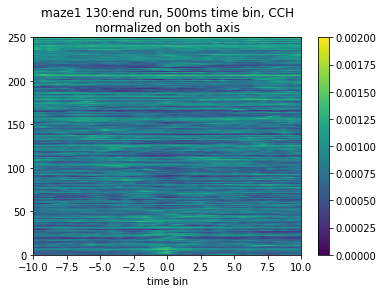

In [86]:
CCH_nn = CCH_plot/CCH_plot.sum(axis=0)
plt.imshow(CCH_nn,aspect='auto',extent=(-10,10,0,250),vmax=0.002)
plt.title('maze1 130:end run, 500ms time bin, CCH\nnormalized on both axis')
plt.xlabel('time bin')
plt.colorbar()

## Explore time bin size

In [74]:
binsize_list = 0.004+0.001*np.arange(30)
binsize_list

array([0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01 , 0.011, 0.012,
       0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02 , 0.021,
       0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03 ,
       0.031, 0.032, 0.033])

In [75]:
# explore time bin size
l = CCH.shape[0]
All_Rs = []
All_Ps = []
for binsize in binsize_list:
    CCH_pbe = get_CCH(DELAYS_pbe,binsize=binsize,bins=39)
    Rs = np.zeros(l)
    Ps = np.zeros(l)
    for i in range(l):
        Rs[i], Ps[i] = pearsonr(CCH[i,:],CCH_pbe[i,:])
    All_Rs.append(Rs)
    All_Ps.append(Ps)

In [77]:
print('place cell pairs with place field difference less than n spatial bins: optimal bin size')
for lm in range(4,30):
    RR = np.array(All_Rs)
    PP = np.array(All_Ps)
    RR = RR[:,np.where(np.abs(pairs_dis)<lm)[0]]
    PP = PP[:,np.where(np.abs(pairs_dis)<lm)[0]]
    sig_r_val = []
    for i in range(len(binsize_list)):
        idx = np.where((PP[i,:]<0.01) & (RR[i,:]>0))[0]
        sig_r_val.append(np.nansum(RR[i,idx]))
    sig_r_val = np.array(sig_r_val)
    print(str(lm)+': '+ str(binsize_list[sig_r_val.argmax()]))

place cell pairs with place field difference less than n spatial bins: optimal bin size
4: 0.025
5: 0.025
6: 0.025
7: 0.029
8: 0.029
9: 0.029
10: 0.028
11: 0.028
12: 0.028
13: 0.028
14: 0.028
15: 0.028
16: 0.028
17: 0.027
18: 0.028
19: 0.028
20: 0.028
21: 0.028
22: 0.021
23: 0.021
24: 0.021
25: 0.028
26: 0.027
27: 0.027
28: 0.027
29: 0.027


In [78]:
RR = np.array(All_Rs)
PP = np.array(All_Ps)
RR.shape,PP.shape, pairs_dis.shape

((30, 1225), (30, 1225), (1225,))

In [110]:
# lm = 16
# RR = RR[:,np.where(np.abs(pairs_dis)<lm)[0]]
# PP = PP[:,np.where(np.abs(pairs_dis)<lm)[0]]
# RR.shape,PP.shape

((20, 1264), (20, 1264))

0.027

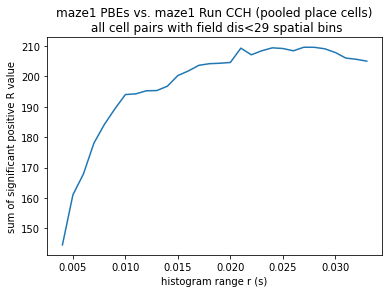

In [79]:
sig_r_val = []
for i in range(len(binsize_list)):
    idx = np.where((PP[i,:]<0.01) & (RR[i,:]>0))[0]
    sig_r_val.append(np.sum(RR[i,idx]))

sig_r_val = np.array(sig_r_val)
plt.plot(binsize_list,sig_r_val)
plt.xlabel('histogram range r (s)')
plt.ylabel('sum of significant positive R value')
plt.title('maze1 PBEs vs. maze1 Run CCH (pooled place cells)\n all cell pairs with field dis<'+str(lm)+' spatial bins')
binsize_list[sig_r_val.argmax()]

In [89]:
np.where((PP[1,:]<0.01)&(RR[1,:]<0)),np.where((PP[1,:]<0.01)&(RR[1,:]>0))

((array([  24,   73,   91,  132,  178,  181,  188,  242,  488,  499,  517,
          531,  551,  552,  675,  677,  694,  701,  719,  868,  940, 1007,
         1010, 1035, 1099, 1113, 1115, 1136, 1145, 1146, 1149, 1156, 1165,
         1193, 1195, 1230, 1255, 1292, 1301, 1321, 1329, 1345, 1378, 1400,
         1442, 1480, 1484, 1501, 1507, 1514, 1516, 1604, 1607, 1635, 1637,
         1653, 1659, 1662, 1663, 1664, 1708, 1721, 1734, 1740, 1812, 1836,
         1841, 1882, 1887, 1888, 1889, 1901, 1907, 1960, 1984, 2016, 2020,
         2025, 2036, 2043, 2050, 2052]),),
 (array([   6,   12,   13,   29,   41,   43,   47,   50,   53,   59,   66,
           70,   71,   72,   74,   76,   77,   78,   80,   81,   82,   86,
           87,   96,   97,   99,  103,  107,  111,  113,  116,  119,  121,
          124,  126,  127,  128,  135,  136,  137,  138,  148,  152,  153,
          157,  163,  166,  167,  169,  175,  179,  182,  189,  198,  199,
          200,  209,  216,  218,  222,  226,  227,  229, 

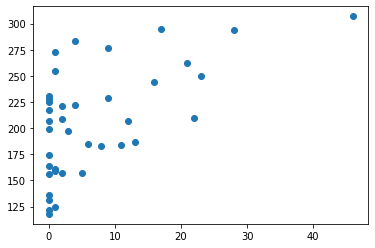

In [94]:
i=43
plt.scatter(CCH_pbe[i,:],CCH[i,:])

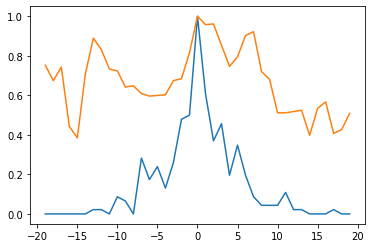

In [95]:
plt.plot(np.arange(-19,20),CCH_pbe[i,:]/np.max(CCH_pbe[i,:]))
plt.plot(np.arange(-19,20),CCH[i,:]/np.max(CCH[i,:]))

In [9]:
def get_delays_pbebin(place_cell,spikes,field,r=40):
    DELAYS = []
    pairs_dis = []
    K = len(PBEs_origin.support.data)

    for idx1 in range(len(place_cell)):
        cell1 = place_cell[idx1]
        for idx2 in range(idx1+1, len(place_cell)):
            cell2 = place_cell[idx2]

            delays = []
            for k in range(K):
                seg = spikes[spikes.support[k]].data
                l = len(seg)
                seg_spk1 = seg[cell1,:]
                seg_spk2 = seg[cell2,:]
                
                for i in np.where(seg_spk1!=0)[0]:
                    segseg = seg_spk2[max(0,i-r):min(l,i+r)]
                    for j in np.where(segseg!=0)[0]:
                        delays.append(np.ones(seg_spk1[i]*segseg[j])*(i-j-max(0,i-r)))
                        
                        
                        
            pairs_dis.append(field[idx1]-field[idx2])
            if len(delays)>0:
                DELAYS.append(np.concatenate(delays))
            else:
                DELAYS.append(np.array([]))

    pairs_dis = np.array(pairs_dis)
    
    return pairs_dis, DELAYS

In [12]:
pairs_dis, DELAYS = get_delays_pbebin(place_cell,spikes,field)
len(DELAYS),pairs_dis.shape

KeyboardInterrupt: 

In [ ]:
savemat('PBEplottings.mat',{"CCH_plot": CCH_plot,"CCH_plot_unscaledPBE": CCH_plot_unscaledPBE, "CCH_plot_pbe": CCH_plot_pbe,"sig_r_val":sig_r_val,"binsize_list":binsize_list})

In [ ]:
binsize_list[np.argmax(np.array(sig_r_val))]

In [ ]:
plt.plot(binsize_list,np.nanmean(RR,axis=1),'o')
plt.xlabel('histogram range r (s)')
plt.ylabel('R')
plt.title('Average Pearson R across cell pairs')

In [ ]:
plt.plot(binsize_list,np.nanmean(PP,axis=1),'o')
plt.xlabel('histogram range r (s)')
plt.ylabel('P')
plt.title('Average Pearson P across cell pairs')

In [ ]:
from matplotlib.font_manager import FontProperties

In [ ]:
def plot_CCH(CCH,pairs_dis,r=4,dis_abs=False):
    """
    Parameters
    ---------------------
    CCH: cross-correlogram of all pairs of place cells, size of (#place_cell*(#place_cell-1)/2,bins)
    pairs_dis: pairwise distances of place fields, size of (#place_cell*(#place_cell-1)/2, )
    r: scalar, binsize*(bins+1)/2, the true histogram range on either side of 0, just be used for axis ticks
    dis_abs: True, place cell pairs sorted by absolute values of field distance
    """
    CCH_n = CCH/CCH.max(axis=1)[:,np.newaxis]
    CCH_n[CCH.max(axis=1)==0,:] = np.zeros_like(CCH[0,:])
    if dis_abs:
        order_pair = np.argsort(np.abs(pairs_dis))
    else:
        order_pair = np.argsort(pairs_dis)
    CCH_plot = CCH_n[order_pair[::-1],:]
    
    font=FontProperties()
    font.set_name('Helvetica')
    fig = plt.figure(figsize=(4,3),dpi=300)
    ax1 = fig.add_subplot(111)
    ax1.imshow(CCH_plot,aspect='auto',extent=(-39,39,0,250))
    ax1.set_xlabel('Bin Index')
    ax1.set_xticks([-30,-15,0,15,30])
    ax2 = ax1.twiny()
    ax2.set_xlabel('Time Delay (s)')
    ax2.set_xlim(-r, r)
    ax2.set_xticks(np.array([-3,-1.5,0,1.5,3])/4*r)
#     plt.imshow(CCH_plot,aspect='auto',extent=(-r,r,pairs_dis[order_pair[-1]],pairs_dis[order_pair[0]]))

    if dis_abs:
        ax1.set_ylabel(f'Place Field Distance ({CCH.shape[0]} pairs)')
    else:
        ax1.set_ylabel(f'Place Field Distance ({CCH.shape[0]} pairs)')
    
    return CCH_plot

In [ ]:
CCH_plot = plot_CCH(CCH,pairs_dis,r=4,dis_abs=True)
plt.title('Maze2 Running data in 100ms time bin\n [1400:end]',fontdict={'fontweight':'bold'})
# plt.savefig('/home/kemerelab/Downloads/EEG/figures/PBE/run_cch_100ms_2x.svg')

In [ ]:
DELAYS_pbe = np.load('delays_PBEsbin_allplacecell.npz',allow_pickle=True)['DELAYS']
pairs_dis_pbe = np.load('delays_PBEsbin_allplacecell.npz',allow_pickle=True)['pairs_dis']

In [ ]:
binsize=0.005
CCH_pbe = get_CCH(DELAYS_pbe,binsize=binsize,bins=79)
r = binsize*(79+1)/2
CCH_pbe.shape,r

In [ ]:
CCH_plot_unscaledPBE = plot_CCH(CCH_pbe,pairs_dis,r=r,dis_abs=True)
plt.title('Maze2 PBEs in 5ms time bin',fontdict={'fontweight':'bold'})
# plt.savefig('/home/kemerelab/Downloads/EEG/figures/PBE/pbe_cch_2ms_2x.svg')

In [ ]:
CCH_n = CCH_plot/CCH_plot.sum(axis=0)
plt.imshow(CCH_n[:500,:],aspect='auto',extent=(-40,40,0,250),vmax=0.004)
plt.colorbar()

In [ ]:
CCH_pbe_n1.shape

In [ ]:
CCH_pbe_n1 = CCH_plot_unscaledPBE/CCH_plot_unscaledPBE.sum(axis=0)
plt.imshow(CCH_pbe_n1[:500,:],aspect='auto',extent=(-40,40,0,250),vmax=0.006)
plt.colorbar()
plt.title('PBEs in 4ms')

In [ ]:
# CCH_pbe_n = CCH_plot_unscaledPBE/CCH_plot_unscaledPBE.sum(axis=0)
plt.imshow(CCH_pbe_n,aspect='auto',extent=(-40,40,0,250),vmax=0.006)
plt.colorbar()
plt.title('PBEs in 7ms')

<a id='MAP'></a>
## MAP Bayesian posterior to decide PBE time bin

In [ ]:
seg_tc_fwd_sm = savgol_filter(seg_tc_fwd,5,2,axis=0)
seg_tc_bwd_sm = savgol_filter(seg_tc_bwd,5,2,axis=0)

In [ ]:
plt.plot(seg_tc_fwd[:,2])
plt.plot(seg_tc_fwd_sm[:,2])

In [ ]:
seg_tc = np.vstack((seg_tc_fwd_sm,seg_tc_bwd_sm))
seg_tc.shape

In [ ]:
seg_tc[seg_tc<0]=0

In [ ]:
np.min(seg_tc[seg_tc>0])/10

In [ ]:
seg_tc = seg_tc + np.min(seg_tc[seg_tc>0])/10

In [ ]:
spikes.shape, seg_tc.shape

In [ ]:
seg_tc.min()

In [ ]:
llh = -np.sum(seg_tc,axis=1)[:,np.newaxis]+np.log(seg_tc).dot(spikes)

In [ ]:
np.sum(seg_tc,axis=1)

In [ ]:
llh.max(axis=0).shape

In [ ]:
poslist=np.concatenate((np.arange(30),np.arange(30)))
poslist

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(poslist[llh.argmax(axis=0)])
plt.plot(position/position.max()*30)
plt.xlim([1000,1900])

In [ ]:
llh.sum()

In [ ]:
llh_pm = -np.sum(seg_tc,axis=1)[:,np.newaxis]+np.log(seg_tc).dot(spikes[np.random.permutation(109),:])
llh_pm.sum()

In [ ]:
del llh_pm

In [ ]:
PBEs_origin

In [ ]:
timebin_list = np.arange(1,30)*0.001
timebin_list

In [ ]:
llh_pbe = []
length_pbe = []
for timebin in timebin_list:
    spikes = PBEs_origin.bin(ds=timebin).data
    seg_tc_tb = seg_tc*timebin*10
    llh_ori = -np.sum(seg_tc_tb,axis=1)[:,np.newaxis]+np.log(seg_tc_tb).dot(spikes)
    llh_pbe.append(llh_ori.max(axis=0))
    length_pbe.append(spikes.shape[1])

llh_pbe_total = []
for l in llh_pbe:
    llh_pbe_total.append(l.sum())
plt.plot(llh_pbe_total)

In [ ]:
llh_pbe[0].max(axis=0).shape

In [ ]:
llh_pbe_total = []
for l in llh_pbe:
    llh_pbe_total.append(l.mean())
plt.plot(llh_pbe_total)